In [5]:
import pandas as pd
import numpy as np

# Load your datasets
df1 = pd.read_csv("coin_gecko_2022-03-16.csv")
df2 = pd.read_csv("coin_gecko_2022-03-17.csv")

# Add date column for traceability
df1["date"] = "2022-03-16"
df2["date"] = "2022-03-17"

# Combine the datasets
df = pd.concat([df1, df2], ignore_index=True)

#convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Convert relevant columns to numeric
cols_to_convert = ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# === Feature Engineering ===

# 1. Price volatility (24h absolute change)
df['price_volatility_24h'] = df['24h'].abs()

# 2. Liquidity score = volume / volatility
epsilon = 1e-6  # avoid division by zero
df['liquidity_score'] = df['24h_volume'] / (df['price_volatility_24h'] + epsilon)

# 3. Absolute price changes over time
df['price_change_1h'] = df['1h'].abs()
df['price_change_7d'] = df['7d'].abs()

# 4. Log-transformed volume and market cap
df['log_volume'] = np.log1p(df['24h_volume'])
df['log_mkt_cap'] = np.log1p(df['mkt_cap'])

# 5. Liquidity level (categorical label)
quantiles = df['liquidity_score'].quantile([0.25, 0.75])
low, high = quantiles[0.25], quantiles[0.75]

def classify_liquidity(score):
    if score <= low:
        return 'Low'
    elif score >= high:
        return 'High'
    else:
        return 'Medium'

df['liquidity_level'] = df['liquidity_score'].apply(classify_liquidity)

# Select final feature set
df_engineered = df[['coin', 'symbol', 'date', 'price', '24h_volume', 'price_volatility_24h',
                    'liquidity_score', 'price_change_1h', 'price_change_7d',
                    'log_volume', 'log_mkt_cap', 'liquidity_level']]

# Preview
print(df_engineered.head())


       coin symbol       date         price    24h_volume  \
0   Bitcoin    BTC 2022-03-16  40859.460000  3.539076e+10   
1  Ethereum    ETH 2022-03-16   2744.410000  1.974870e+10   
2    Tether   USDT 2022-03-16      1.000000  5.793497e+10   
3       BNB    BNB 2022-03-16    383.430000  1.395854e+09   
4  USD Coin   USDC 2022-03-16      0.999874  3.872274e+09   

   price_volatility_24h  liquidity_score  price_change_1h  price_change_7d  \
0                 0.030     1.179653e+12            0.022            0.055   
1                 0.034     5.808269e+11            0.024            0.065   
2                 0.001     5.787709e+13            0.001            0.000   
3                 0.028     4.985015e+10            0.018            0.004   
4                 0.000     3.872274e+15            0.001            0.000   

   log_volume  log_mkt_cap liquidity_level  
0   24.289717    27.370943            High  
1   23.706353    26.513545            High  
2   24.782587    25.104857   

In [6]:
from warnings import filterwarnings
filterwarnings("ignore")
df1 = df_engineered.copy()
df1['liquidity_level'].replace({'High':2,'Medium':1,'Low':0}, inplace=True)
df1['liquidity_level'] = df1['liquidity_level'].astype(int)

In [15]:
df1.info()
df1.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   coin                  1000 non-null   object        
 1   symbol                1000 non-null   object        
 2   date                  1000 non-null   datetime64[ns]
 3   price                 1000 non-null   float64       
 4   24h_volume            993 non-null    float64       
 5   price_volatility_24h  993 non-null    float64       
 6   liquidity_score       993 non-null    float64       
 7   price_change_1h       993 non-null    float64       
 8   price_change_7d       992 non-null    float64       
 9   log_volume            993 non-null    float64       
 10  log_mkt_cap           1000 non-null   float64       
 11  liquidity_level       1000 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 93.9+ KB


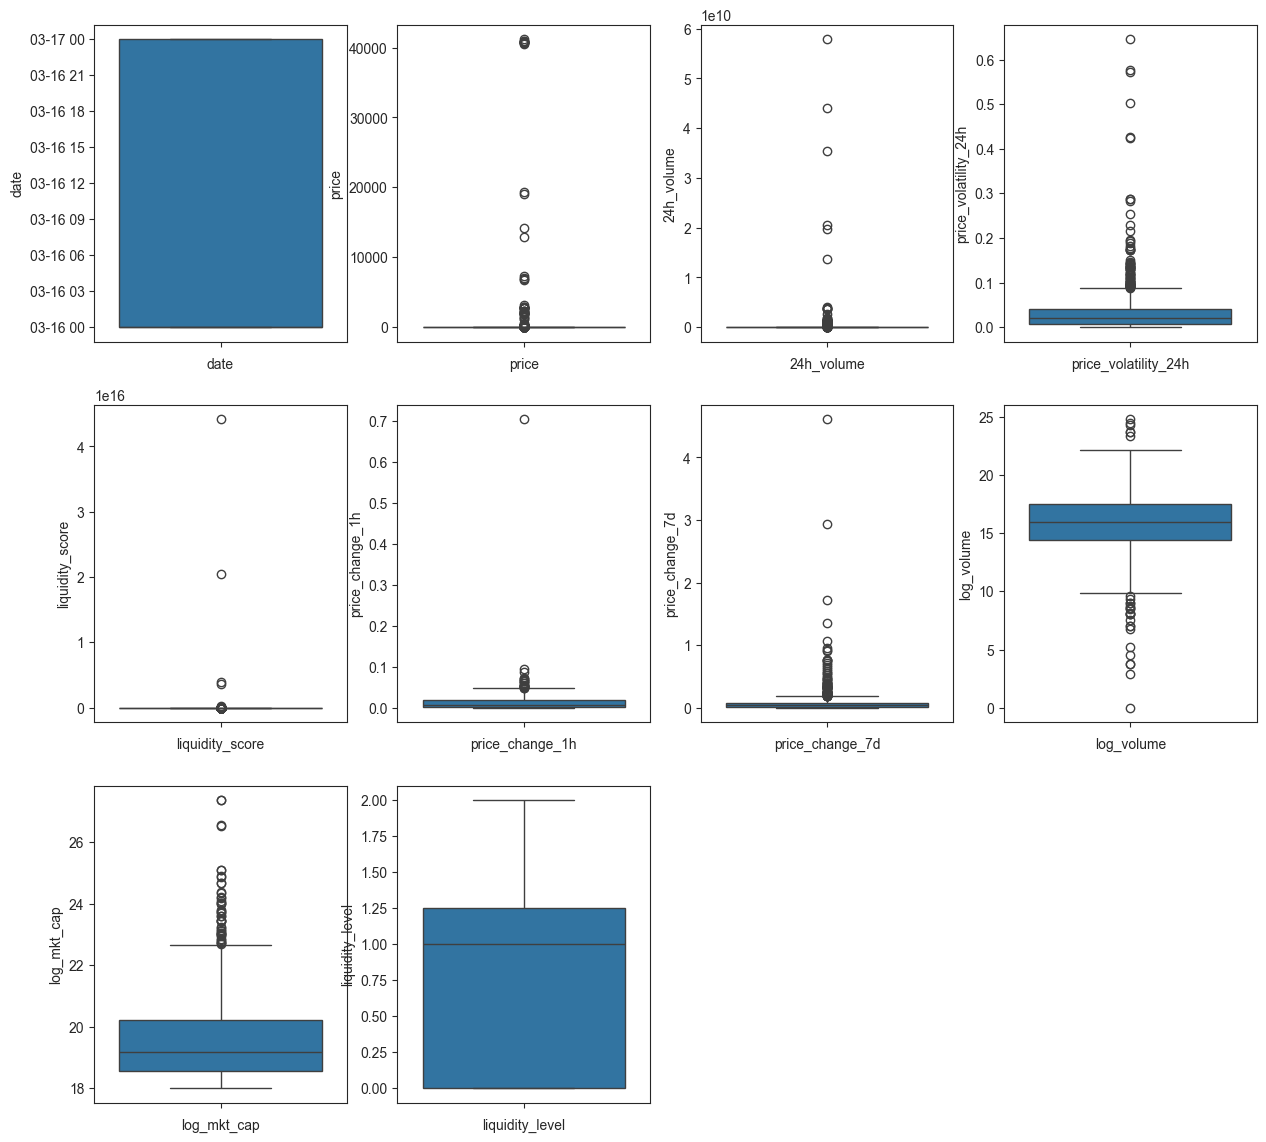

In [38]:
#Check Outliers
import matplotlib.pyplot as plt 
import seaborn as sns 
num_features = [features for features in df1.columns if df1[features].dtype != 'O']
plt.figure(figsize=(15,14))
for i in range(len(num_features)):
    plt.subplot(3,4,i+1)
    sns.set_style('ticks')
    plt.xlabel(num_features[i])
    px = sns.boxplot(df1[num_features[i]])

In [39]:
outlier_features = ['price','24h_volume','price_volatility_24h','liquidity_score','price_change_1h','price_change_7d','log_volume','log_mkt_cap']

In [44]:
#Replace outliers with upper_limit and lower_limit
for col in outlier_features:
    per_25 = df1[col].quantile(0.25)
    per_75 = df1[col].quantile(0.75)
    IQR = per_75 - per_25
    upper_limit = per_75 + 1.5 * IQR
    lower_limit = per_25 - 1.5 * IQR 
    df1[col] = np.where(df1[col] > upper_limit, upper_limit, np.where(df1[col] < lower_limit, lower_limit, df1[col]))

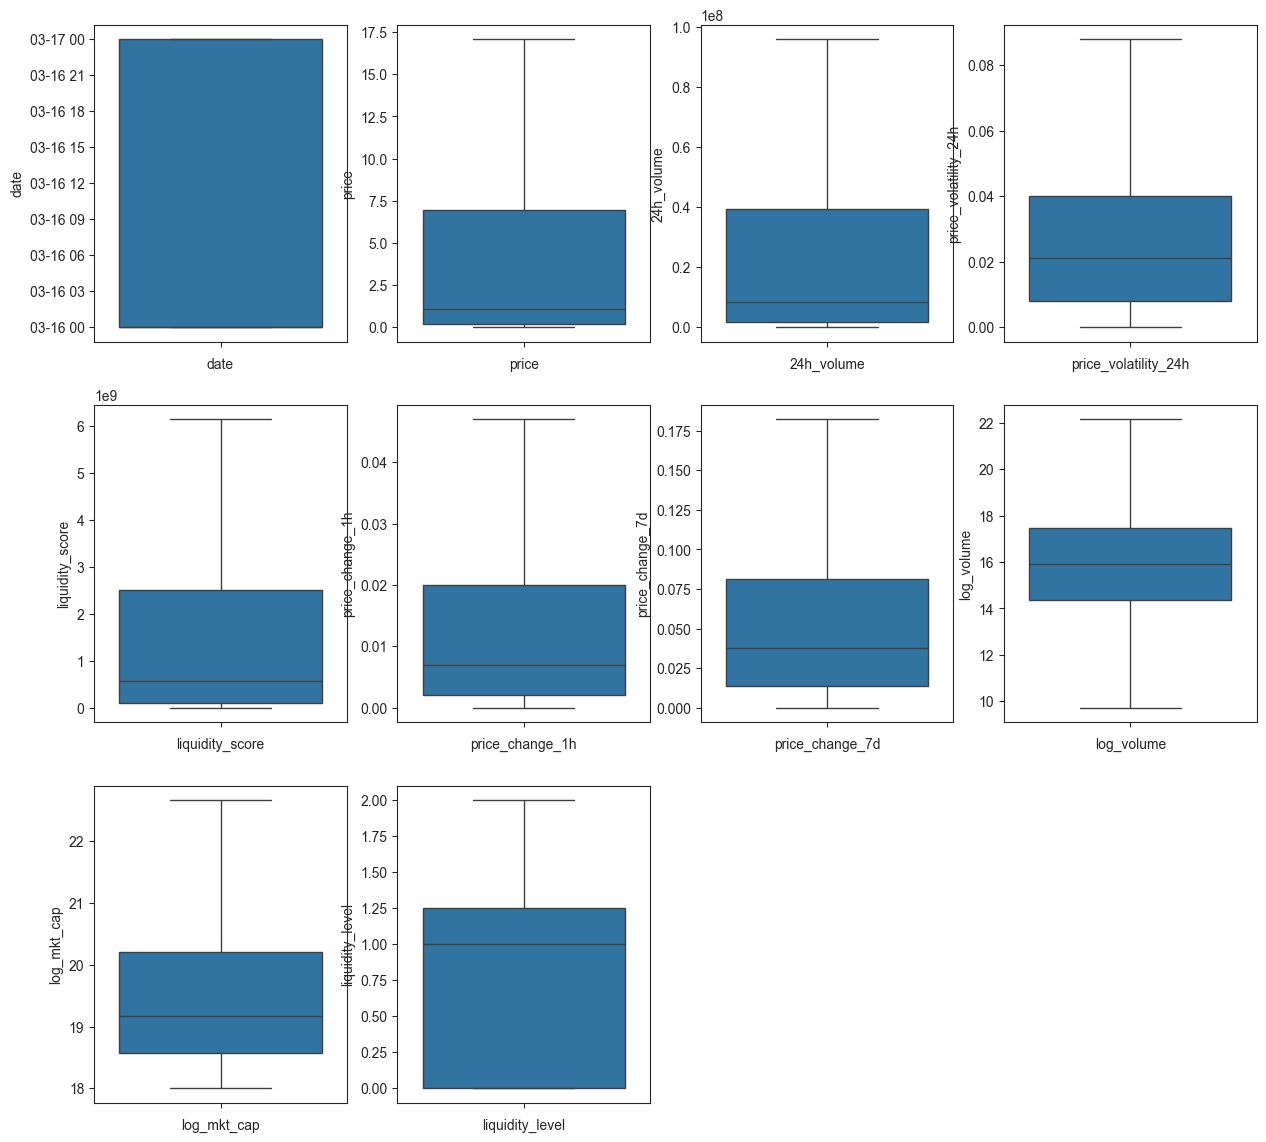

In [45]:
#Check again the outliers 

plt.figure(figsize=(15,14))
for i in range(len(num_features)):
    plt.subplot(3,4,i+1)
    sns.set_style('ticks')
    plt.xlabel(num_features[i])
    px = sns.boxplot(df1[num_features[i]])

In [47]:
# stock_data['liquidity_score'] = stock_data['24h_volume'] / df_clean['mkt_cap']
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ['price', '24h_volume', 'price_volatility_24h', 'liquidity_score', 'price_change_1h','price_change_7d','log_volume','log_mkt_cap']
X = df1[features]
y = df1['liquidity_level']


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression':LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'SVC': SVC(),
    'Random Forest ': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost':XGBClassifier()
}

In [48]:

def best_model(x_train , x_test , y_train , y_test ,models):
    scores = []
    model_name = []
    for i in range(len(list(models.values()))):
        model = list(models.values())[i]
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        score = accuracy_score(y_test,y_pred)
        scores.append(score)
        model_name.append(list(models.keys())[i])
    for sc , mod in zip(scores,model_name):
        print(f"{mod} : {sc}")
best_model(X_train , X_test , y_train , y_test ,models)

Logistic Regression : 0.949748743718593
Decision Tree : 1.0
SVC : 0.9547738693467337
Random Forest  : 1.0
Gradient Boosting : 1.0
XGBoost : 1.0


We can see the Decision tree Classifier , Random forest Classifier, Gradient Boosting and XGBoost have the highest accuracy score

we can choose anyone from them : we select XGBoost Classifier

In [50]:
model = XGBClassifier()

model.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [52]:
#save the model
import pickle
pickle.dump(model, open('model.pkl','wb'))